In [2]:
# Take Twitter API key and set as an Operating System environment variable via the command line.
# It is not advisable to store the token in the code for security purposes
import os

os.environ['TOKEN'] = r'<BEARER-TOKEN>'

The following code on how to use Python to query the Twitter API was referenced from 

https://towardsdatascience.com/an-extensive-guide-to-collecting-tweets-from-twitter-api-v2-for-academic-research-using-python-3-518fcb71df2a

In [1]:
!pip install bokeh
!pip install jupyter-server-proxy && jupyter serverextension enable --py jupyter-server-proxy
!jupyter labextension install @jupyterlab/server-proxy
!pip install bokeh_wordcloud2
!pip install sqlalchemy
!pip install nltk
!pip install tweet-preprocessor
!pip install wordcloud
!pip install dash
!pip install jupyter-dash
!pip install dash-bootstrap-components

Traceback (most recent call last):
  File "/home/codespace/.local/bin/jupyter-serverextension", line 8, in <module>
    sys.exit(main())
  File "/home/codespace/.local/lib/python3.10/site-packages/jupyter_core/application.py", line 276, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
    app.start()
  File "/home/codespace/.local/lib/python3.10/site-packages/notebook/serverextensions.py", line 289, in start
    super().start()
  File "/home/codespace/.local/lib/python3.10/site-packages/jupyter_core/application.py", line 265, in start
    self.subapp.start()
  File "/home/codespace/.local/lib/python3.10/site-packages/notebook/serverextensions.py", line 208, in start
    self.toggle_server_extension_python(arg)
  File "/home/codespace/.local/lib/python3.10/site-packages/notebook/serverextensions.py", line 197, in toggle_server_extension_pyt

In [28]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd

import sqlite3
from sqlite3 import Error

from sqlalchemy import create_engine, Integer, JSON, Column, Sequence, select, MetaData
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

Part 1: Data stream to database

In [5]:
def auth():
    return os.getenv('TOKEN')

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [6]:
# Inputs for the request
# We will query all tweets about the Navy for the last week
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Navy"
start_time = "2022-11-13T00:00:00.000Z"
end_time = "2022-11-18T00:00:00.000Z"
max_results = 100

In [7]:
url = create_url(keyword, start_time,end_time, max_results)
twitter_response = connect_to_endpoint(url[0], headers, url[1])

print(json.dumps(twitter_response, indent=4, sort_keys=True))

Endpoint Response Code: 200
{
    "data": [
        {
            "author_id": "213885823",
            "conversation_id": "1593310028685008896",
            "created_at": "2022-11-17T23:59:59.000Z",
            "edit_history_tweet_ids": [
                "1593393545649557505"
            ],
            "id": "1593393545649557505",
            "in_reply_to_user_id": "93770330",
            "lang": "en",
            "public_metrics": {
                "like_count": 2,
                "quote_count": 0,
                "reply_count": 1,
                "retweet_count": 0
            },
            "referenced_tweets": [
                {
                    "id": "1593386567061716996",
                    "type": "replied_to"
                }
            ],
            "reply_settings": "everyone",
            "source": "Twitter for iPhone",
            "text": "@savanha_2012 @Josh_Snyder11 Saw a tweet earlier that said girl Mahomes looks like she runs a captain Ds like it\u2019s the Nav

Now that we have some data, let's store it in a database for future use. The following code was taken from

https://www.sqlitetutorial.net/sqlite-python/creating-database/

In [8]:
# Save the results to a sqlite database

def create_database(db_file):
    """ create an SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object and cursor or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        c = conn.cursor()
        return conn, c
    except Error as e:
        print(e)

    return conn

def create_table(c, create_table_sql):
    """ create a table from the create_table_sql statement
    :param c: Cursor object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql(c, sql_cmd):
    """ create a table from the create_table_sql statement
    :param c: Cursor object
    :param sql_cmd: an SQL statement
    :return:
    """
    try:
        c.execute(sql_cmd)
    except Error as e:
        print(e)

# Create our database
create_database(r"twitter.db")
print("Database created")

# Establish a connection to the database, which we can now read and write from
conn, c = create_connection(r"twitter.db")
print("Connection established")

# Initiatialize what tables are in the database

# This is our SQL statement to create a table to store our twitter data in plaintext
sql_create_twitter_table = """ CREATE TABLE IF NOT EXISTS twitter (
                                        id integer PRIMARY KEY ASC,
                                        twitter_json text NOT NULL
                                    ); """

# Create the table
create_table(c, sql_create_twitter_table)
print("Table created")

# Verify that the table was created by querying what tables are in the database
sql_tables_query = """SELECT name FROM sqlite_master WHERE type='table';"""
c.execute(sql_tables_query)
print(c.fetchall())

# Close the connection to the database
conn.close()

2.6.0
Database created
Connection established
Table created
[('twitter',)]


Now that our database is created, we can store the twitter data in the database. Instead of using raw SQL commands, we are going to practice using SQLalchemy, a python library purpose built for managing multiple types of databases in a more efficient/safe manner.

In [41]:
EntityBase = declarative_base()

# Make sure the table and column names match the table already created
class Item(EntityBase):
    __tablename__ = "twitter"
    id = Column(Integer, Sequence("item_id_seq"), primary_key=True, nullable=False)
    twitter_json = Column(JSON, nullable=True)

# Setup a database connection.
engine = create_engine("sqlite:///twitter.db")

Session = sessionmaker(bind=engine)
session = Session()

# You can create new tables using this line of code if desired
#EntityBase.metadata.create_all(engine)

# Declare a new row
first_item = Item()
first_item.twitter_json = twitter_response

# Insert it into the database
session.add(first_item)
session.commit()

# Close the session and dispose engine
session.close()
engine.dispose()

Part 2: Front end application

Now that we have some data in a database, we can work on the web application which will be built in bokeh

In [2]:
import sqlalchemy as db

import nltk
nltk.download('stopwords')
nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pandas as pd
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/codespace/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/codespace/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/codespace/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/codespace/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars 

In [3]:
# Query all data from the database using sqlalchemy

engine = db.create_engine('sqlite:///twitter.db')
connection = engine.connect()
metadata = db.MetaData()
twitter = db.Table('twitter', metadata, autoload=True, autoload_with=engine)

# Equivalent to "SELECT * FROM twitter"
query = db.select([twitter])

ResultProxy = connection.execute(query)

ResultSet = ResultProxy.fetchall()

ResultSet

[(1, '{"data": [{"text": "@savanha_2012 @Josh_Snyder11 Saw a tweet earlier that said girl Mahomes looks like she runs a captain Ds like it\\u2019s the Navy ... (108277 characters truncated) ... _id": "1593393545649557505", "oldest_id": "1593391893139755009", "result_count": 100, "next_token": "b26v89c19zqg8o3fpzhkh9u1zfboor10bhvrkgrbedlrx"}}')]

In [4]:
# Convert the results to a dataframe, convert the row back to json from string

df = pd.DataFrame(ResultSet)
df.columns = ResultSet[0].keys()
df["twitter_json"] = df["twitter_json"].apply(json.loads) 

df.head()

,id,twitter_json
0,1,{'data': [{'text': '@savanha_2012 @Josh_Snyder...


In [5]:
# Iterate through the dataframe and pull out all of the text from the tweets

tweet_text = []

for row in df["twitter_json"]:
    for tweet in row["data"]:
        tweet_text.append(tweet["text"])

tweet_text = pd.Series(tweet_text)

tweet_text = tweet_text.astype(str)

tweet_text

0     @savanha_2012 @Josh_Snyder11 Saw a tweet earli...
1     RT @ToddGloria: History in the making! Honored...
2     お待たせしております、Beersシャツの予約開始です！\nカラーはBLACK、NAVY、WI...
3     new challenge just dropped: try to make a swif...
4     RT @USNavy: The #EOD Team assigned to Carrier ...
                            ...                        
95    RT @larwoolf: Rock Hudson \nNovember 17, 1925 ...
96    RT @StephenM: If President Biden cared one bit...
97    RT @Jaejeong0807: [Free Q&amp;A session about ...
98    @US_Navy_Ret_MD @Pazkc1971 Coast Guard has a f...
99    @mirmops I bought from old navy and gap. They ...
Length: 100, dtype: object

In [6]:
# We can clean the text up a bit, so we will use a series of NLP preprocessing techniques
# to get rid of stop words, lemmitization, and tokenizing

# https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529

from nltk.tokenize import TweetTokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
import preprocessor as p
import re

def clean_text(input_text):
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words

    input_text = p.clean(input_text)

    input_text = input_text.replace('\d+', '')
    input_text = input_text.lower()

    input_text = [(lemmatizer.lemmatize(w)) for w in \
                                            w_tokenizer.tokenize((input_text))]
    
    input_text = remove_punctuation(input_text)
    
    stop_words = stopwords.words('english')

    new_stopwords = ["navy"]
    stop_words.extend(new_stopwords)

    filtered_sentence = [item for item in input_text if item not in stop_words]

    return filtered_sentence

tweet_text_clean = tweet_text.apply(clean_text)

tweet_text_clean

0     [saw, tweet, earlier, said, girl, mahomes, loo...
1     [history, making, honored, join, fellow, san, ...
2                [beersblacknavywine, red, 3black, bot]
3     [new, challenge, dropped, try, make, swiftie, ...
4     [team, assigned, carrier, strike, group, took,...
                            ...                        
95    [rock, hudson, november, october, first, scree...
96    [president, biden, cared, one, bit, sovereignt...
97    [free, q, session, korean, military, hi, army,...
98    [coast, guard, ha, full, deck, puerto, rico, w...
99                     [bought, old, gap, equally, bad]
Length: 100, dtype: object

In [7]:
# Now were going to break up the words and count each occurrence of words

#words = tweet_text_clean.str.split()
word_counts = pd.value_counts(tweet_text_clean.apply(pd.Series).stack())

word_counts = pd.Series(word_counts)

word_counts = pd.DataFrame({'words':word_counts.index, 'weights':word_counts.values})

word_counts

/tmp/ipykernel_8155/3919876288.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word_counts = pd.value_counts(tweet_text_clean.apply(pd.Series).stack())


,words,weights
0,u,16
1,wa,12
2,qatar,10
3,like,10
4,check,9
...,...,...
667,code,1
668,gerade,1
669,exetlos,1
670,continue,1



Now we're going to create our Bokeh app and visualize a wordcloud to see what people are saying 
on twitter about the Navy
https://docs.bokeh.org/en/test/docs/user_guide/jupyter.html

https://hub.gke2.mybinder.org/user/joranbeasley-bo-dcloud-notebook-u2f1j1l5/notebooks/bokeh_wordcloud2.ipynb

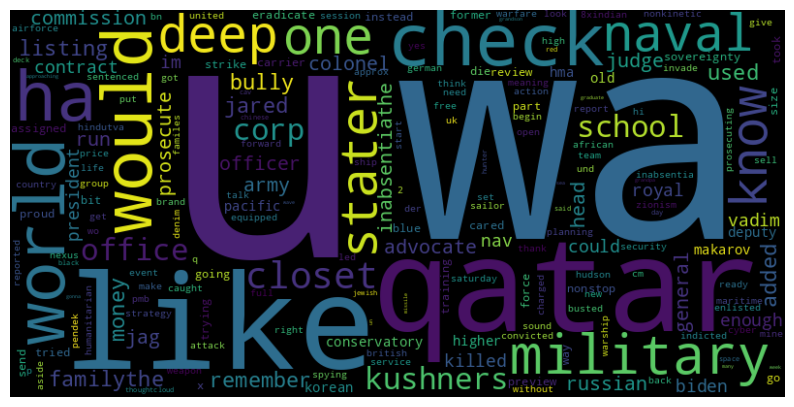

In [8]:
Here is a version

data = word_counts.set_index('words').to_dict()['weights']

from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
# Now here is a version of an app built in Dash, which is built on top of Flask and Plotly.js

import dash
from dash import html
from dash import dcc
import dash_bootstrap_components as dbc
import plotly.express as px

from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
from io import BytesIO
from wordcloud import WordCloud
import base64
import dash.dependencies as dd

app = dash.Dash(__name__,external_stylesheets=[dbc.themes.LUX])
app.layout = html.Div([
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardBody([
                    html.H5('Word Cloud',className='text-center'),
                    html.Img(id="image_wc"),
                ])
            ])
        ],width={'size':12,"offset":0,'order':1},style={'padding-left' : 25,'padding-right' : 25},className='text-center'),
    ])
])
    
def plot_wordcloud(data):
    d = {a: x for a, x in data.values}
    wc = WordCloud(background_color='white', width=1080, height=360)
    wc.fit_words(d)
    return wc.to_image()

@app.callback(dd.Output('image_wc', 'src'), [dd.Input('image_wc', 'id')])
def make_image(b):
    img = BytesIO()
    plot_wordcloud(data=word_counts).save(img, format='PNG')
    return 'data:image/png;base64,{}'.format(base64.b64encode(img.getvalue()).decode())
   
if __name__ == "__main__":
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


/tmp/ipykernel_8155/440384671.py:10: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/tmp/ipykernel_8155/440384671.py:11: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [20/Nov/2022 03:04:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:04:32] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_7_0m1668912826.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:04:32] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_7_0m1668912826.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:04:32] "GET /_dash-component-suites/dash/deps/react@16.v2_7_0m1668912826.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 03:04:32] "GET /_dash-

In [17]:
# Now here is a version of how to run in Bokeh

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh_wordcloud2 import WordCloud2

word_data_source = ColumnDataSource(word_counts)

sdp = WordCloud2(source=word_data_source,wordCol="words",sizeCol="weights",color='blue')
output_notebook()
show(sdp)

/home/codespace/.python/current/lib/python3.10/site-packages/bokeh_wordcloud2/bokeh_wordcloud2.py:44: RuntimeWarning: Properties {'classes'} in class WordCloud2 were previously declared on a parent class. It never makes sense to do this. Redundant properties should be deleted here, or onthe parent class. Override() can be used to change a default value of a base class property.
  class WordCloud2(_WordCloud2Meta):
Compilation failed:

../../home/codespace/.python/current/lib/python3.10/site-packages/bokeh_wordcloud2/typescript/extension_bokeh_wordcloud2.ts:32:14 - error TS2515: Non-abstract class 'WordClickEvent' does not implement inherited abstract member 'event_values' from class 'BokehEvent'.

32 export class WordClickEvent extends BokehEvent{
                ~~~~~~~~~~~~~~
../../home/codespace/.python/current/lib/python3.10/site-packages/bokeh_wordcloud2/typescript/extension_bokeh_wordcloud2.ts:38:26 - error TS2339: Property '_to_json' does not exist on type 'BokehEvent'.

38     

AssertionError: 

In [32]:
# Use to create requirements.txt to recreate the project easily

!pip install pipreqs
!pip install nbconvert

!jupyter nbconvert --output-dir="./reqs" --to script twitter-bokeh.ipynb
!cd reqs
!pipreqs --force

[NbConvertApp] Converting notebook twitter-bokeh.ipynb to script
[NbConvertApp] Writing 12581 bytes to reqs/twitter-bokeh.py
INFO: Successfully saved requirements file in /workspaces/codespaces-jupyter/requirements.txt


Congratulations! Now you should understand the basics of how data can be streamed from APIs and stored in a database, then accessed and used in a web application to visualize as a decision aid. With some slight modifications, this code can be updated to run continuously on a cloud platform such as AWS or Azure. Part 1 would stream tweets on an interval to the database at a set frequency. Part two would need to be modified to continuously query the database to update the live visualization and would be deployed as a Bokeh app on another instance.